In [90]:
!pip install -q kaggle

In [91]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"taban123456","key":"0e301cbc4b47db5ed837878cdfc1c469"}'}

In [92]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [93]:
!kaggle datasets download -d jangedoo/utkface-new

utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [94]:
!unzip utkface-new

Archive:  utkface-new.zip
replace UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# !pip install wandb

In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import os
import wandb
from tqdm import tqdm
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [130]:
images = []
ages = []
for image_name in os.listdir('/content/utkface_aligned_cropped/UTKFace')[0:9000]:
  parts = image_name.split('_')
  ages.append(int(parts[0]))
  image = cv2.imread(f'/content/utkface_aligned_cropped/UTKFace/{image_name}')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  images.append(image )

In [131]:
wandb.init(project="Age_detection_transfer_learnning")

In [132]:
images = pd.Series(images,name = 'Images')
ages = pd.Series(ages,name='Ages')
df = pd.concat([images,ages],axis=1)
df.head()

,Images,Ages
0,"[[[11, 11, 11], [11, 11, 11], [11, 11, 11], [1...",28
1,"[[[253, 236, 216], [253, 237, 214], [255, 237,...",1
2,"[[[199, 154, 25], [200, 155, 26], [203, 155, 3...",26
3,"[[[101, 93, 72], [104, 96, 75], [111, 100, 80]...",56
4,"[[[161, 149, 135], [159, 147, 133], [154, 142,...",55


22


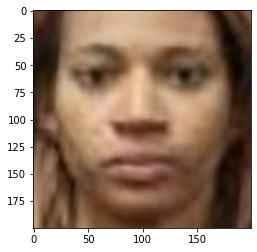

In [133]:
print(df['Ages'][10])
plt.imshow(df['Images'][10])

In [134]:
under_30 = []
for i in range(len(df)):
  if 20<=df['Ages'].iloc[i]<=40:
    under_30.append(df.iloc[i])
under_30 = pd.DataFrame(under_30)
under_30 = under_30.sample(frac = 0.3)
uper_30 = df[df['Ages']>30]
df = pd.concat([under_30, uper_30])

In [135]:
X = []
Y = []
for i in range(len(df)):
  df['Images'].iloc[i] = cv2.resize(df['Images'].iloc[i],(width,height))
  X.append(df['Images'].iloc[i])
  Y.append(df['Ages'].iloc[i])
X = np.array(X)
Y = np.array(Y)
X = X.reshape((-1, X.shape[3], X.shape[1], X.shape[2]))
Y = Y.reshape(Y.shape[0], 1)
X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


torch.Size([5607, 3, 224, 224])


In [136]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [137]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet50(pretrained=True)

In [ ]:
model

In [138]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features,1)

In [139]:
ct = 0
for child in model.children():
  ct +=1
  if ct < 45:
     for param in child.parameters():
         param.requires_grad =True


In [140]:
model = model.to(device)

In [141]:
config = wandb.config
config.learning_rate = 0.01
config.batch_size =32
config.epochs = 50

In [156]:
transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.RandomHorizontalFlip(),
                                # transforms.RandomRotation(10),
                                transforms.Resize((70,70)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

In [143]:
class CustomTensorDataset():
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform):

        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        y = self.tensors[1][index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [144]:
def train_val_dataset(dataset, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['test'] = Subset(dataset, test_idx)
    return datasets
dataset = CustomTensorDataset(tensors=(X, Y), transform=transform)
# dataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/MNIST_persian', transform=transform)
print(len(dataset))
datasets = train_val_dataset(dataset)
print(len(datasets['train']))
print(len(datasets['test']))
train_data_loader = torch.utils.data.DataLoader(datasets['train'], batch_size=config.batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(datasets['test'], batch_size=config.batch_size, shuffle=False)
print(len(train_data_loader))
print(len(test_data_loader))

5607
4205
1402
132
44


In [145]:
optimizer = torch.optim.Adam(model.parameters(),lr=config.learning_rate)
loss_function = nn.SmoothL1Loss()

In [146]:
def calc_acc(preds,labels):
  _,preds_max = torch.max(preds, 1)
  acc = torch.sum(preds_max==labels.data,dtype = torch.float64)/len(preds)
  return acc

In [147]:
# train
wandb.watch(model)


for epoch in range(config.epochs):
  train_loss = 0.0
  train_acc = 0.0
  for images, labels in tqdm(train_data_loader):

    images, labels = images.to(device), labels.to(device)
    # print(images.shape)
    optimizer.zero_grad()
    # images = images.float()
    preds = model(images)

    loss = loss_function(preds,  labels)
    loss.backward()

    optimizer.step()

    train_loss += loss
    # train_acc +=calc_acc(preds, labels)

  total_loss = train_loss/len(train_data_loader)
  # total_acc = train_acc/len(train_data_loader)
  if epoch % 2 == 0:
     wandb.log({"train_loss": total_loss})
    #  wandb.log({"train_acc": total_acc})

  # total_acc = train_acc/len(train_data_loader)
  print(f"Epoch:{epoch}: Train_Loss:{total_loss}")
  
  print("-------------------------------------")

100%|██████████| 132/132 [00:29<00:00,  4.51it/s]


Epoch:0: Train_Loss:12.56352424621582
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.54it/s]


Epoch:1: Train_Loss:11.098736763000488
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.53it/s]


Epoch:2: Train_Loss:10.837411880493164
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.55it/s]


Epoch:3: Train_Loss:10.782669067382812
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.53it/s]


Epoch:4: Train_Loss:10.480208396911621
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.55it/s]


Epoch:5: Train_Loss:10.555742263793945
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.53it/s]


Epoch:6: Train_Loss:10.456945419311523
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.52it/s]


Epoch:7: Train_Loss:10.192394256591797
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.53it/s]


Epoch:8: Train_Loss:10.334352493286133
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.54it/s]


Epoch:9: Train_Loss:10.174774169921875
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.54it/s]


Epoch:10: Train_Loss:10.18529987335205
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.52it/s]


Epoch:11: Train_Loss:10.12668228149414
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.54it/s]


Epoch:12: Train_Loss:9.87341594696045
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.54it/s]


Epoch:13: Train_Loss:9.631457328796387
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.54it/s]


Epoch:14: Train_Loss:9.712686538696289
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.52it/s]


Epoch:15: Train_Loss:9.557256698608398
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.54it/s]


Epoch:16: Train_Loss:9.617339134216309
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.53it/s]


Epoch:17: Train_Loss:9.344368934631348
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.53it/s]


Epoch:18: Train_Loss:9.227951049804688
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.54it/s]


Epoch:19: Train_Loss:9.125574111938477
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.55it/s]


Epoch:20: Train_Loss:8.873973846435547
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.53it/s]


Epoch:21: Train_Loss:8.894588470458984
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.51it/s]


Epoch:22: Train_Loss:8.693774223327637
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.54it/s]


Epoch:23: Train_Loss:8.482857704162598
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.54it/s]


Epoch:24: Train_Loss:8.24767017364502
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.54it/s]


Epoch:25: Train_Loss:8.341073036193848
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.54it/s]


Epoch:26: Train_Loss:7.8407745361328125
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.54it/s]


Epoch:27: Train_Loss:7.843362808227539
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.53it/s]


Epoch:28: Train_Loss:7.555140018463135
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.52it/s]


Epoch:29: Train_Loss:7.266580581665039
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.51it/s]


Epoch:30: Train_Loss:7.037919521331787
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.53it/s]


Epoch:31: Train_Loss:6.751967906951904
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.53it/s]


Epoch:32: Train_Loss:6.467146873474121
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.51it/s]


Epoch:33: Train_Loss:6.291750431060791
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.53it/s]


Epoch:34: Train_Loss:5.975675582885742
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.53it/s]


Epoch:35: Train_Loss:5.82096529006958
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.54it/s]


Epoch:36: Train_Loss:5.751206874847412
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.50it/s]


Epoch:37: Train_Loss:5.355778694152832
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.53it/s]


Epoch:38: Train_Loss:5.088376998901367
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.53it/s]


Epoch:39: Train_Loss:4.891386985778809
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.53it/s]


Epoch:40: Train_Loss:4.770352363586426
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.53it/s]


Epoch:41: Train_Loss:4.516783237457275
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.53it/s]


Epoch:42: Train_Loss:4.358527183532715
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.53it/s]


Epoch:43: Train_Loss:4.289394855499268
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.54it/s]


Epoch:44: Train_Loss:4.142106056213379
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.50it/s]


Epoch:45: Train_Loss:3.97012996673584
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.54it/s]


Epoch:46: Train_Loss:3.7746496200561523
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.52it/s]


Epoch:47: Train_Loss:3.7122724056243896
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.54it/s]


Epoch:48: Train_Loss:3.429155111312866
-------------------------------------


100%|██████████| 132/132 [00:29<00:00,  4.52it/s]

Epoch:49: Train_Loss:3.4506685733795166
-------------------------------------


In [148]:

wandb.watch(model)


for epoch in range(config.epochs):
  test_loss = 0.0
  # train_acc = 0.0
  for images, labels in tqdm(test_data_loader):

    images, labels = images.to(device), labels.to(device)
    # print(images.shape)
    optimizer.zero_grad()
    # images = images.float()
    preds = model(images)

    loss = loss_function(preds,  labels)
    loss.backward()

    optimizer.step()

    test_loss += loss
    # train_acc +=calc_acc(preds, labels)

  total_loss = test_loss/len(test_data_loader)
  # total_acc = train_acc/len(test_data_loader)
  if epoch % 2 == 0:
     wandb.log({"test_loss": total_loss})
    #  wandb.log({"acc": total_acc})

  # total_acc = train_acc/len(train_data_loader)
  print(f"Epoch:{epoch}: Test_Loss:{total_loss}")
  
  print("-------------------------------------")

100%|██████████| 44/44 [00:09<00:00,  4.55it/s]


Epoch:0: Test_Loss:9.516376495361328
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.52it/s]


Epoch:1: Test_Loss:7.436850547790527
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.55it/s]


Epoch:2: Test_Loss:5.999696254730225
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.52it/s]


Epoch:3: Test_Loss:5.198537349700928
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.53it/s]


Epoch:4: Test_Loss:4.773521423339844
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.52it/s]


Epoch:5: Test_Loss:4.428098678588867
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.55it/s]


Epoch:6: Test_Loss:4.075834274291992
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.53it/s]


Epoch:7: Test_Loss:3.7283973693847656
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.54it/s]


Epoch:8: Test_Loss:3.5203685760498047
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.43it/s]


Epoch:9: Test_Loss:3.4170658588409424
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.55it/s]


Epoch:10: Test_Loss:3.4001965522766113
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.51it/s]


Epoch:11: Test_Loss:3.173274278640747
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.54it/s]


Epoch:12: Test_Loss:3.1315135955810547
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.53it/s]


Epoch:13: Test_Loss:2.6754894256591797
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.53it/s]


Epoch:14: Test_Loss:2.5307159423828125
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.53it/s]


Epoch:15: Test_Loss:2.708585739135742
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.55it/s]


Epoch:16: Test_Loss:2.5648202896118164
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.51it/s]


Epoch:17: Test_Loss:3.0317273139953613
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.53it/s]


Epoch:18: Test_Loss:2.821694850921631
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.54it/s]


Epoch:19: Test_Loss:2.6677865982055664
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.53it/s]


Epoch:20: Test_Loss:2.2999913692474365
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.51it/s]


Epoch:21: Test_Loss:2.537066698074341
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.47it/s]


Epoch:22: Test_Loss:2.684534788131714
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.52it/s]


Epoch:23: Test_Loss:2.7076990604400635
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.55it/s]


Epoch:24: Test_Loss:2.4096903800964355
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.50it/s]


Epoch:25: Test_Loss:2.3390533924102783
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.54it/s]


Epoch:26: Test_Loss:3.2084076404571533
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.51it/s]


Epoch:27: Test_Loss:4.19243860244751
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.55it/s]


Epoch:28: Test_Loss:4.18101167678833
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.51it/s]


Epoch:29: Test_Loss:3.4169201850891113
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.55it/s]


Epoch:30: Test_Loss:2.4920990467071533
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.44it/s]


Epoch:31: Test_Loss:1.926304817199707
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.51it/s]


Epoch:32: Test_Loss:1.7121638059616089
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.53it/s]


Epoch:33: Test_Loss:1.370926856994629
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.53it/s]


Epoch:34: Test_Loss:1.3897981643676758
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.53it/s]


Epoch:35: Test_Loss:1.3476871252059937
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.54it/s]


Epoch:36: Test_Loss:1.251833200454712
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.53it/s]


Epoch:37: Test_Loss:1.1556638479232788
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.53it/s]


Epoch:38: Test_Loss:1.386832594871521
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.51it/s]


Epoch:39: Test_Loss:1.526812195777893
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.51it/s]


Epoch:40: Test_Loss:1.4279543161392212
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.50it/s]


Epoch:41: Test_Loss:1.5679675340652466
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.51it/s]


Epoch:42: Test_Loss:1.776049256324768
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.51it/s]


Epoch:43: Test_Loss:1.4622211456298828
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.52it/s]


Epoch:44: Test_Loss:1.3738425970077515
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.44it/s]


Epoch:45: Test_Loss:1.438866138458252
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.54it/s]


Epoch:46: Test_Loss:2.677539825439453
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.51it/s]


Epoch:47: Test_Loss:3.8089849948883057
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.52it/s]


Epoch:48: Test_Loss:3.279148817062378
-------------------------------------


100%|██████████| 44/44 [00:09<00:00,  4.51it/s]


Epoch:49: Test_Loss:2.591698408126831
-------------------------------------


In [152]:
torch.save(model.state_dict(),"Age_detection.pth")

In [153]:
transformation = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((70,70)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [154]:
#inference
import cv2
import numpy as np

model.eval()

img = cv2.imread("/content/2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# img = cv2.resize(img,(28,28))
tensor = transformation(img).unsqueeze(0).to(device)

preds = model(tensor)

preds = preds.cpu().detach().numpy()
print(preds)
# output = np.argmax(preds)
# output

[[45.547512]]
